In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from optimization_tuned import epsilon_nondominated,HypervolumeMetric, Hypervolume
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
)
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant
import pickle
warnings.filterwarnings("ignore")

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation(6)

## Scenarios to determine epsilon spacing

In [3]:
# ScenResul = pd.read_csv('data\OpenScenRes.csv').drop(columns="Unnamed: 0")

In [4]:
# ScenResul_mean =ScenResul.mean()

In [5]:
epsilon = []


## Reference Scenario for optimizer


In [5]:
#load it
with open("data\ScenariosOpenExplo", 'rb') as file2:
    Scenarios = pickle.load(file2)

In [6]:
Scenarios

[Scenario({'discount rate 0': 3.5, 'discount rate 1': 3.5, 'discount rate 2': 3.5, 'A.0_ID flood wave shape': 17, 'A.1_Bmax': 190.0, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5, 'A.2_Bmax': 190.0, 'A.2_pfail': 0.5498741874471307, 'A.2_Brate': 1.5, 'A.3_Bmax': 190.0, 'A.3_pfail': 0.6347090611234307, 'A.3_Brate': 1.5, 'A.4_Bmax': 190.0, 'A.4_pfail': 0.5499818336684257, 'A.4_Brate': 1.5, 'A.5_Bmax': 190.0, 'A.5_pfail': 0.156920283799991, 'A.5_Brate': 1.5}),
 Scenario({'discount rate 0': 3.5, 'discount rate 1': 3.5, 'discount rate 2': 3.5, 'A.0_ID flood wave shape': 17, 'A.1_Bmax': 190.0, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5, 'A.2_Bmax': 190.0, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5, 'A.3_Bmax': 190.0, 'A.3_pfail': 0.11443669931031764, 'A.3_Brate': 1.5, 'A.4_Bmax': 190.0, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5, 'A.5_Bmax': 190.0, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5}),
 Scenario({'discount rate 0': 3.5, 'discount rate 1': 3.5, 'discount rate 2': 3.5, 'A.0_ID flood wave shape': 17, 'A.1_Bmax': 190.0, 'A.1_pfail

## Optimizer

In [8]:
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress

# we need to store our results for each seed
results = []
convergences = []
n = 1

with MultiprocessingEvaluator(dike_model) as evaluator:
    # we run again for 5 seeds
    for i in range(n):
        # we create 2 covergence tracker metrics
        # the archive logger writes the archive to disk for every x nfe
        # the epsilon progress tracks during runtime
        convergence_metrics = [
            ArchiveLogger(
                r"./Archive",
                [l.name for l in dike_model.levers],
                [o.name for o in dike_model.outcomes],
                base_filename=f"{i}.tar.gz",
            ),
            
            EpsilonProgress(),
        ]

        result, convergence = evaluator.optimize(
            nfe=100,
            searchover="levers",
            epsilons=[0.1] * len(dike_model.outcomes),
            convergence=convergence_metrics,
            reference = Scenarios[0]
        )

        results.append(result)
        convergences.append(convergence)

100%|████████████████████████████████████████| 100/100 [00:14<00:00,  6.69it/s]


In [9]:
k = r"./Archive"

## Create complete archive

In [22]:
all_archives[0]

{0: Empty DataFrame
 Columns: [0_RfR 0, 0_RfR 1, 0_RfR 2, 1_RfR 0, 1_RfR 1, 1_RfR 2, 2_RfR 0, 2_RfR 1, 2_RfR 2, 3_RfR 0, 3_RfR 1, 3_RfR 2, 4_RfR 0, 4_RfR 1, 4_RfR 2, EWS_DaysToThreat, A.1_DikeIncrease 0, A.1_DikeIncrease 1, A.1_DikeIncrease 2, A.2_DikeIncrease 0, A.2_DikeIncrease 1, A.2_DikeIncrease 2, A.3_DikeIncrease 0, A.3_DikeIncrease 1, A.3_DikeIncrease 2, A.4_DikeIncrease 0, A.4_DikeIncrease 1, A.4_DikeIncrease 2, A.5_DikeIncrease 0, A.5_DikeIncrease 1, A.5_DikeIncrease 2, A.5_Expected Number of Deaths, A.5_Expected Annual Damage, Expected Evacuation Costs, Expected Annual Damage, Total Investment Costs, Expected Number of Deaths]
 Index: []
 
 [0 rows x 37 columns],
 100:    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
 0        0        0        0        1        0        0        1        0   
 1        0        1        1        0        0        0        1        0   
 2        0        1        1        0        0        0        0        1   
 

In [15]:
all_archives = []

for i in range(n):
    archives = ArchiveLogger.load_archives(k+ "\\" + f"{i}.tar.gz")
    for key in archives.keys():
        del archives[key]["Unnamed: 0"]
    print(archives)
    all_archives.append(archives)

{0: Empty DataFrame
Columns: [0_RfR 0, 0_RfR 1, 0_RfR 2, 1_RfR 0, 1_RfR 1, 1_RfR 2, 2_RfR 0, 2_RfR 1, 2_RfR 2, 3_RfR 0, 3_RfR 1, 3_RfR 2, 4_RfR 0, 4_RfR 1, 4_RfR 2, EWS_DaysToThreat, A.1_DikeIncrease 0, A.1_DikeIncrease 1, A.1_DikeIncrease 2, A.2_DikeIncrease 0, A.2_DikeIncrease 1, A.2_DikeIncrease 2, A.3_DikeIncrease 0, A.3_DikeIncrease 1, A.3_DikeIncrease 2, A.4_DikeIncrease 0, A.4_DikeIncrease 1, A.4_DikeIncrease 2, A.5_DikeIncrease 0, A.5_DikeIncrease 1, A.5_DikeIncrease 2, A.5_Expected Number of Deaths, A.5_Expected Annual Damage, Expected Evacuation Costs, Expected Annual Damage, Total Investment Costs, Expected Number of Deaths]
Index: []

[0 rows x 37 columns], 100:    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0        0        0        0        1        0        0        1        0   
1        0        1        1        0        0        0        1        0   
2        0        1        1        0        0        0        0        1   
3        

In [16]:
dike_model_problem =dike_model

## Calc metrics

In [17]:
reference_set

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.5_Expected Number of Deaths,A.5_Expected Annual Damage,Expected Evacuation Costs,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
0,0,0,0,1,0,0,1,0,0,1,...,1,3,6,4,0.019741,1.762101e+07,0.000000,1.762101e+07,9.781220e+08,0.019741
1,0,1,1,0,0,0,1,0,0,1,...,1,3,1,6,0.009809,8.777176e+06,0.000000,8.777176e+06,1.092177e+09,0.009809
2,0,1,1,0,0,0,0,1,0,0,...,4,7,9,5,0.000000,0.000000e+00,112.983164,2.830657e+06,9.115497e+08,0.000665
3,1,0,0,0,0,0,0,1,0,1,...,1,7,3,0,0.000000,0.000000e+00,0.000000,0.000000e+00,1.161655e+09,0.000000


In [18]:
from optimization_tuned import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem

problem = to_problem(dike_model_problem, searchover="levers")
print(results)

reference_set = epsilon_nondominated(results, [0.1] * (len(dike_model.outcomes)), problem)
print('REFERENCE SET')
print(reference_set)
# hv = HypervolumeMetric(reference_set, problem)
# print(1)
gd = GenerationalDistanceMetric(reference_set, problem, d=1)
print(2)
ei = EpsilonIndicatorMetric(reference_set, problem)
print(3)
ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
print(4)
sm = SpacingMetric(problem)
print(5)


metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        print(f'nfe: {nfe}')
        print(f'archive: {archive}')
        if int(nfe) == 0:
            continue
        scores = {
            "generational_distance": gd.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed.append(metrics)

[   0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0        0        0        0        1        0        0        1        0   
1        0        1        1        0        0        0        1        0   
2        0        1        1        0        0        0        0        1   
3        1        0        0        0        0        0        0        1   

   2_RfR 2  3_RfR 0  ...  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
0        0        1  ...                   1                   3   
1        0        1  ...                   1                   3   
2        0        0  ...                   4                   7   
3        0        1  ...                   1                   7   

   A.5_DikeIncrease 1  A.5_DikeIncrease 2  A.5_Expected Number of Deaths  \
0                   6                   4                       0.019741   
1                   1                   6                       0.009809   
2                   9                   5   

## Plot

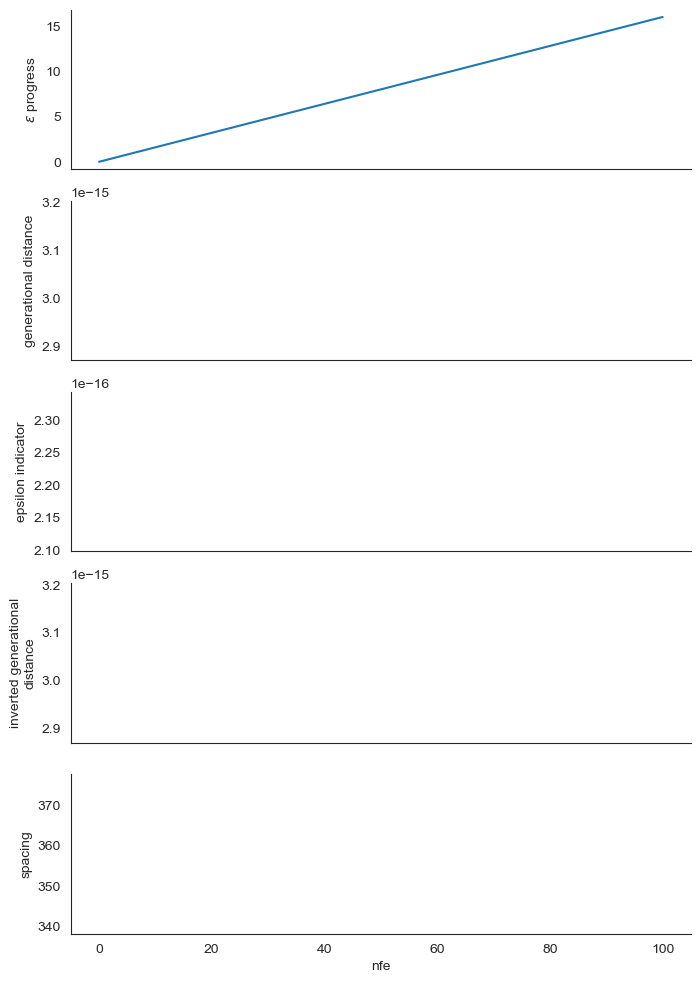

In [19]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=5, figsize=(8, 12), sharex=True)

ax2, ax3, ax4, ax5, ax6 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    # ax1.plot(metrics.nfe, metrics.hypervolume)
    # ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")


sns.despine(fig)

plt.show()

In [20]:
print(metrics)

   generational_distance  epsilon_indicator   inverted_gd     spacing  nfe
0           3.036703e-15       2.220446e-16  3.036703e-15  357.906234  100


## Old Stuff

In [ ]:
# change outcomes so direction is undesirable
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in dike_model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize

with MultiprocessingEvaluator(model) as evaluator:
    results1 = evaluator.optimize(
        nfe=1000, searchover="uncertainties", epsilons=[0.1] * len(model.outcomes)
    )

In [ ]:
from ema_workbench.analysis import parcoords

data = results1.loc[:, [o.name for o in model.outcomes]]

# get the minimum and maximum values as present in the dataframe
limits = parcoords.get_limits(data)

# we know that the lowest possible value for all objectives is 0
limits.loc[0, ["utility", "inertia", "reliability", "max_P"]] = 0
# inertia and reliability are defined on unit interval, so their theoretical maximum is 1
limits.loc[1, ["inertia", "reliability"]] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("max_P")
plt.show()


## IMPORTED FROM PIM

In [40]:
from ema_workbench import ScalarOutcome

ema_logging.log_to_stderr(ema_logging.INFO)
# change outcomes so direction is undesirable
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in dike_model_problem.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize

with MultiprocessingEvaluator(dike_model_problem) as evaluator:
    results1 = evaluator.optimize(
        nfe=1000, searchover="levers", epsilons=[0.1] * len(dike_model_problem.outcomes), reference=Scenarios[0]
    )

[MainProcess/INFO] pool started with 8 workers
1098it [03:07,  5.85it/s]                                                      
[MainProcess/INFO] optimization completed, found 17 solutions
[MainProcess/INFO] terminating pool


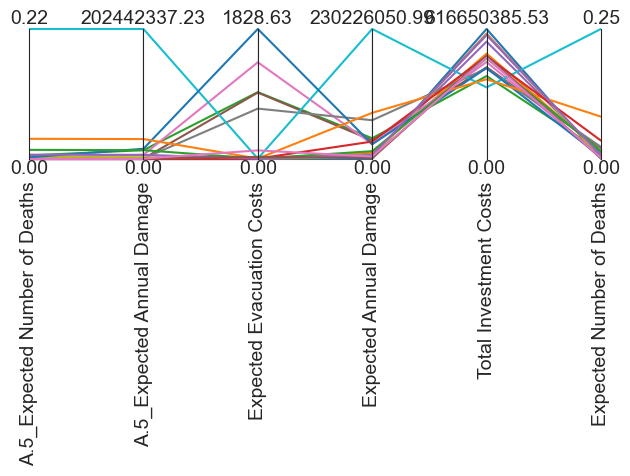

In [41]:
from ema_workbench.analysis import parcoords

data = results1.loc[:, [o.name for o in dike_model_problem.outcomes]]

# get the minimum and maximum values as present in the dataframe
limits = parcoords.get_limits(data)

# we know that the lowest possible value for all objectives is 0
limits.loc[0, ["A.5_Expected Number of Deaths", "A.5_Expected Annual Damage", "Expected Evacuation Costs", "Expected Annual Damage", "Expected Number of Deaths", "Total Investment Costs"]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [42]:
import functools

# our robustness functions
percentile10 = functools.partial(np.percentile, q=10)
percentile90 = functools.partial(np.percentile, q=90)

# convenient short hands
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

robustnes_functions = [
    ScalarOutcome(
        "90th p. A.5_Expected Number of Deaths", kind=MINIMIZE, variable_name="A.5_Expected Number of Deaths", function=percentile90
    ),
    ScalarOutcome(
        "90th p. A.5_Expected Annual Damage", kind=MINIMIZE, variable_name="A.5_Expected Annual Damage", function=percentile90
    ),
    ScalarOutcome(
        "90th p. Expected Evacuation Costs", kind=MINIMIZE, variable_name="Expected Evacuation Costs", function=percentile90
    ),
    ScalarOutcome(
        "90th p. Expected Annual Damage", kind=MINIMIZE, variable_name="Expected Annual Damage", function=percentile90
    ),
    ScalarOutcome(
        "90th p. Total Investment Costs", kind=MINIMIZE, variable_name="Total Investment Costs", function=percentile90
    ),
    ScalarOutcome(
        "90th p. Expected Number of Deaths", kind=MINIMIZE, variable_name="Expected Number of Deaths", function=percentile90
    ),
    
]

In [43]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 10
scenarios = sample_uncertainties(dike_model, n_scenarios)

In [44]:
from ema_workbench.em_framework import ArchiveLogger

nfe = int(100)
with MultiprocessingEvaluator(dike_model) as evaluator:
    robust_results = evaluator.robust_optimize(
        robustnes_functions,
        scenarios,
        nfe=nfe,
        epsilons=[
            0.1,
        ]
        * len(robustnes_functions),
    )

[MainProcess/INFO] pool started with 8 workers
  0%|                                                  | 0/100 [00:00<?, ?it/s][MainProcess/INFO] terminating pool


KeyboardInterrupt: 

In [ ]:
data = robust_results.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis("90th percentile max_p")
plt.show()